# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from multipole import Vlm
from multipole import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [19]:
#case 3 construction
num_particles = 1000
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

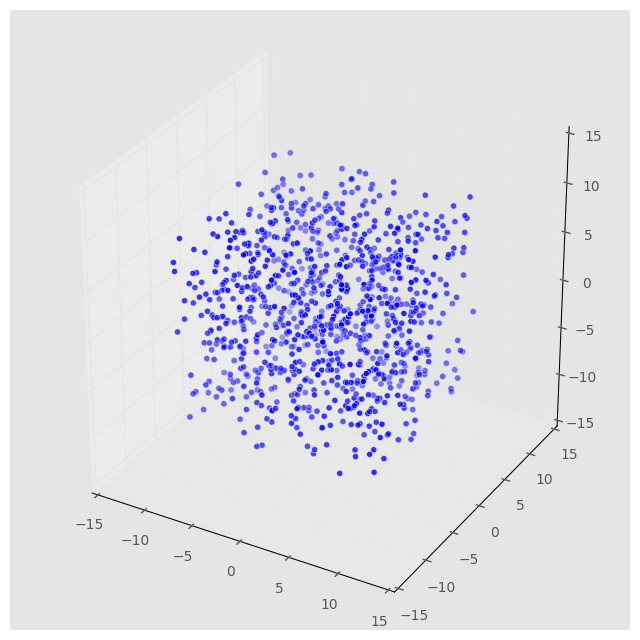

In [20]:
plot_3d(x_i)

In [21]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

In [22]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])

In [23]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    J_i = 0
    for j in range(0,i):
        J_i += pair_potential[j][i]
    for j in range(i+1, num_particles):
        J_i += pair_potential[i][j]
    J_analytic[i] = J_i

J_analytic

array([  87.15417536,   68.52713296,  101.66091964,   96.08949453,
        105.67554471,  107.95259924,  105.45110851,   87.905197  ,
         99.38901976,   96.09890697,  114.01518027,   71.45830146,
         82.54578423,  118.27544625,   71.04938847,   96.79895214,
         95.79339171,   95.32011242,   84.92387009,  101.56265298,
         96.97457148,   89.19122422,   94.94503442,   89.79837474,
         98.13969794,   97.26769102,   74.41523546,  100.75730032,
        105.50037645,   99.92053649,   93.88670713,  112.87795999,
         99.23712947,   96.60126331,   99.16152875,   81.15722646,
         93.89601661,  110.07401645,   98.66335754,  100.90599101,
         91.02442246,   86.99943846,  120.58178197,   86.77991962,
         99.75771662,  110.83968073,   83.01690659,   88.03226285,
        105.18941105,  108.19395754,  100.33619048,   98.50262502,
        119.49753986,   96.45185816,  113.48250848,   74.71668507,
        107.96144187,   89.27384223,   77.80168154,   80.91786

In [24]:
total_energy = 0.5 * sum(J_analytic)
total_energy

47571.978547293205

In [25]:
from multipole import fmm_level as fl
from multipole import fmm_q_source as fq

In [26]:
# build list of q_source
q_source = np.ndarray(shape=(len(x_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])

In [27]:
fmm_level_bottom = fl(3, q_source, 3)

In [28]:
fmm_level_bottom.box_list[9].Olm.Vp

array([[  2.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [ -6.72382117e-04 +0.00000000e+00j,
          6.86793128e-03 +1.41202883e-02j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [  2.83078854e-03 +0.00000000e+00j,
          3.91777031e-04 +5.63064227e-04j,
         -5.18288111e-05 +8.53807369e-05j,
          0.00000000e+00 +0.00000000e+00j],
       [ -1.16758757e-05 +0.00000000e+00j,
          9.58684433e-06 +2.00061116e-05j,
         -2.63812787e-06 +4.70344414e-06j,
         -4.65438091e-07 -4.62091344e-09j]])

In [29]:
f_level_2 = fmm_level_bottom.next_level_construction()

In [30]:
f_level_2.box_list[0].Olm.Vp


array([[  1.30000000e+01 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [  1.17098448e-01 +0.00000000e+00j,
          7.76502259e-03 +6.04546821e-01j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [  2.00348128e-03 +0.00000000e+00j,
          2.66887556e-03 +8.08200157e-03j,
         -1.04020216e-02 +9.83045239e-04j,
          0.00000000e+00 +0.00000000e+00j],
       [ -7.95122520e-04 +0.00000000e+00j,
         -2.95391330e-05 +6.46972835e-04j,
         -1.50413044e-04 +8.69667920e-05j,
         -3.28764831e-05 -2.72707820e-05j]])